In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.utils import all_estimators
import glob

In [5]:
data = pd.read_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/processed/all_city_data_with_pop.csv")

In [6]:
# Filtering columns to be used for modeling
data = data[['geometry', 'city', 'EV_stations', 'parking', 'edges',
             'parking_space', 'civic', 'restaurant', 'park', 'school',
             'node', 'Community_centre', 'place_of_worship', 'university', 'cinema',
             'library', 'commercial', 'retail', 'townhall', 'government',
             'residential', 'population']]
print("data size:", data.shape)
data = data.dropna()
print("data size after dropping na:", data.shape)


data size: (10824, 22)
data size after dropping na: (10129, 22)


In [3]:
# Function to split data into train and test sets
def data_splitter(data, train_cities=None, test_cities=None, test_size=0.2, random_state=42):
    if train_cities is not None:
        train = data[data['city'].isin(train_cities)]
        test = data[data['city'].isin(test_cities)]

        X_train = train.drop(['city','geometry', 'EV_stations'], axis=1)
        y_train = train['EV_stations'].astype(int)
        y_train = y_train.apply(lambda x: 1 if x > 0 else 0)

        X_test = test.drop(['city','geometry', 'EV_stations'], axis=1)
        y_test = test['EV_stations'].astype(int)
        y_test = y_test.apply(lambda x: 1 if x > 0 else 0)
    else:
        X = data.drop(['city','geometry', "EV_stations"], axis=1)
        y = data['EV_stations']
        y = y.apply(lambda x: 1 if x > 0 else 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [7]:
# Define big and small cities
big_cities = ['Berlin', 'Munich', 'Stuttgart', 'Frankfurt']
small_cities = ['Karlsruhe', 'Trier', 'Saarbrücken', 'Mainz']

In [3]:
"""
# Function to run the experiment for a given city
def run_experiment(X_train, X_test, y_train, y_test):
    # Get all classification model classes
    classifiers = all_estimators(type_filter='classifier')

    # Initialize result table
    results = []
    models = {}
    classification_reports = {}

    # Run models and collect results
    for name, ClassifierClass in tqdm(classifiers):
        try:
            # Initialize model
            model = ClassifierClass()
            model.fit(X_train, y_train)
            models[name] = model
            y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')
            auc = roc_auc_score(y_test, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

            # Append results
            results.append([name, accuracy, precision, recall, f1, auc, balanced_accuracy])

            # Save classification report
            report_dict = classification_report(y_test, y_pred, output_dict=True)
            classification_reports[name] = report_dict

        except Exception as e:
            print(f"Error occurred for {name}: {str(e)}")

    # Create a DataFrame from results
    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC", "Balanced Accuracy"])
    results_df = results_df.sort_values(by=['F1-score', 'AUC'], ascending=False)
    results_df.to_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/all_cities_random_shuffle.csv", index=False)

    # Save classification reports to CSV
    classification_reports_df = pd.DataFrame.from_dict(classification_reports, orient='index')
    classification_reports_df.to_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/classification_reports.csv")

    return results_df, models

""""

In [4]:
def run_experiment(X_train, X_test, y_train, y_test):
    classifiers = all_estimators(type_filter='classifier')

    results = []
    models = {}
    classification_reports = {}

    for name, ClassifierClass in tqdm(classifiers):
        try:
            # Initialize model
            model = ClassifierClass()

            # Hyperparameter tuning with GridSearchCV
            param_grid = {}  # Add hyperparameter grid here based on the model

            grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
            grid_search.fit(X_train, y_train)

            # Use the best estimator
            model = grid_search.best_estimator_

            # Fit the model
            model.fit(X_train, y_train)
            models[name] = model
            y_pred = model.predict(X_test)

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro')
            recall = recall_score(y_test, y_pred, average='macro')
            f1 = f1_score(y_test, y_pred, average='macro')
            auc = roc_auc_score(y_test, y_pred)
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

            # Append results
            results.append([name, accuracy, precision, recall, f1, auc, balanced_accuracy])

            # Save classification report
            report_dict = classification_report(y_test, y_pred, output_dict=True)
            classification_reports[name] = report_dict

            # Print classification report
            print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}\n")

        except Exception as e:
            print(f"Error occurred for {name}: {str(e)}")

    results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC", "Balanced Accuracy"])
    results_df = results_df.sort_values(by=['F1-score', 'AUC'], ascending=False)
    results_df.to_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/all_cities_random_shuffle.csv", index=False)

    # Save classification reports to CSV
    classification_reports_df = pd.DataFrame.from_dict(classification_reports, orient='index')
    classification_reports_df.to_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/classification_reports.csv")

    return results_df, models

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

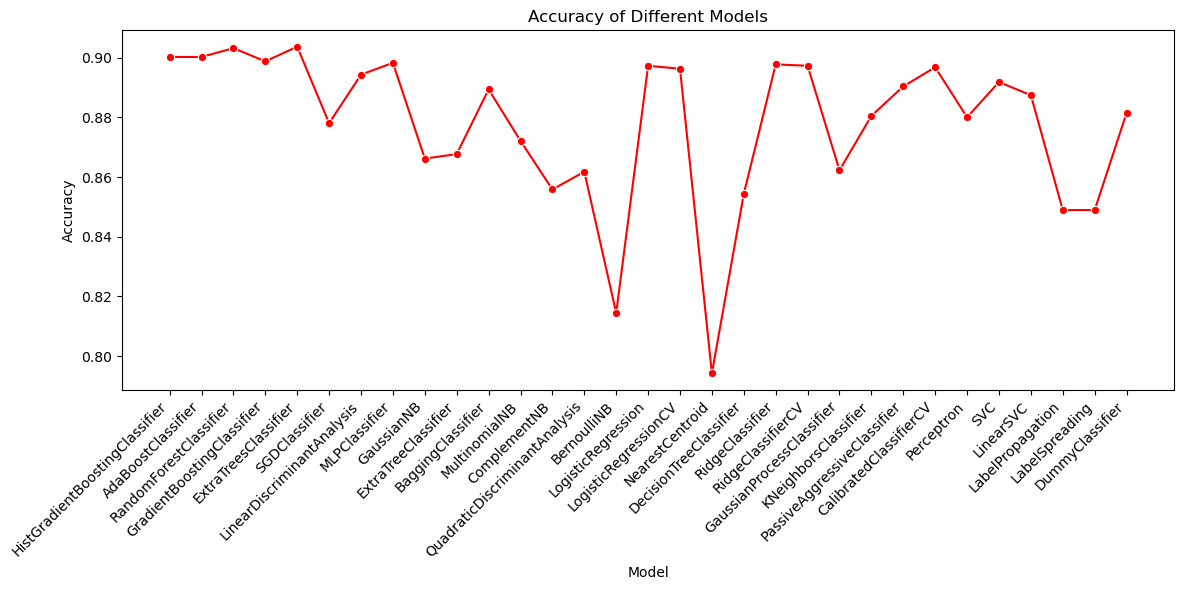

In [22]:
 # Plot the accuracies with error bars
plt.figure(figsize=(12, 6))
sns.lineplot(x='Model', y='Accuracy', data=results_df, marker='o', color= 'red',  err_style="bars", ci=68)
plt.title('Accuracy of Different Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/model_accuracies_line.png")
plt.show()

In [8]:
# Run experiments for big cities
for city in tqdm(big_cities):
    test_cities = [city]
    train_cities = [x for x in big_cities if x != city]
    X_train, X_test, y_train, y_test = data_splitter(data, train_cities=train_cities, test_cities=test_cities)
    results_df, models = run_experiment(X_train, X_test, y_train, y_test)
    results_df.to_csv(f"C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/big_cities_test_city_{city}.csv", index=False)

# Run experiments for small cities
for city in tqdm(small_cities):
    test_cities = [city]
    train_cities = [x for x in small_cities if x != city]
    X_train, X_test, y_train, y_test = data_splitter(data, train_cities=train_cities, test_cities=test_cities)
    results_df, models = run_experiment(X_train, X_test, y_train, y_test)
    results_df.to_csv(f"C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/small_cities_test_city_{city}.csv", index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3395
           1       0.51      0.56      0.54       491

    accuracy                           0.88      3886
   macro avg       0.72      0.74      0.73      3886
weighted avg       0.88      0.88      0.88      3886


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3395
           1       0.44      0.48      0.46       491

    accuracy                           0.86      3886
   macro avg       0.68      0.69      0.69      3886
weighted avg       0.86      0.86      0.86      3886


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86      3395
           1       0.34      0.83      0.49       491

    accuracy                           0.78      3

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3395
           1       0.48      0.48      0.48       491

    accuracy                           0.87      3886
   macro avg       0.70      0.70      0.70      3886
weighted avg       0.87      0.87      0.87      3886


Error occurred for CategoricalNB: index 51 is out of bounds for axis 1 with size 51
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      3395
           1       0.35      0.76      0.48       491

    accuracy                           0.79      3886
   macro avg       0.66      0.78      0.68      3886
weighted avg       0.88      0.79      0.82      3886


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for DummyClassifier:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3395
           1       0.00      0.00      0.00       491

    accuracy                           0.87      3886
   macro avg       0.44      0.50      0.47      3886
weighted avg       0.76      0.87      0.81      3886


Classification Report for ExtraTreeClassifier:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      3395
           1       0.35      0.52      0.42       491

    accuracy                           0.82      3886
   macro avg       0.64      0.69      0.66      3886
weighted avg       0.85      0.82      0.83      3886


Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3395
           1       0.45      0.55      0.49       491

    accuracy                           0.8

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3395
           1       0.39      0.41      0.40       491

    accuracy                           0.84      3886
   macro avg       0.65      0.66      0.65      3886
weighted avg       0.85      0.84      0.85      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3395
           1       0.13      0.07      0.09       491

    accuracy                           0.83      3886
   macro avg       0.50      0.50      0.50      3886
weighted avg       0.78      0.83      0.80      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3395
           1       0.13      0.07      0.09       491

    accuracy                           0.83      3886
   macro avg       0.50      0.50      0.50      3886
weighted avg       0.78      0.83      0.80      3886


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3395
           1       0.42      0.59      0.49       491

    accuracy                           0.85      3886
   macro avg       0.68      0.74      0.70      3886
weighted avg       0.87      0.85      0.86      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3395
           1       0.52      0.32      0.40       491

    accuracy                           0.88      3886
   macro avg       0.71      0.64      0.66      3886
weighted avg       0.86      0.88      0.86      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3395
           1       0.42      0.57      0.48       491

    accuracy                           0.85      3886
   macro avg       0.68      0.73      0.70      3886
weighted avg       0.87      0.85      0.86      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3395
           1       0.44      0.54      0.48       491

    accuracy                           0.85      3886
   macro avg       0.68      0.72      0.70      3886
weighted avg       0.87      0.85      0.86      3886


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3395
           1       0.43      0.56      0.49       491

    accuracy                           0.85      3886
   macro avg       0.68      0.73      0.70      3886
weighted avg       0.87      0.85      0.86      3886


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3395


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3395
           1       0.46      0.26      0.33       491

    accuracy                           0.87      3886
   macro avg       0.68      0.61      0.63      3886
weighted avg       0.84      0.87      0.85      3886


Classification Report for QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      3395
           1       0.38      0.65      0.48       491

    accuracy                           0.82      3886
   macro avg       0.66      0.75      0.68      3886
weighted avg       0.87      0.82      0.84      3886




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 569, in predict
    probs = self.predict_proba(X)
  File "C:\Users\ASUS\a

Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([   2,    9,   17, ..., 3877, 3878, 3879], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3395
           1       0.48      0.54      0.51       491

    accuracy                           0.87      3886
   macro avg       0.71      0.73      0.72      3886
weighted avg       0.88      0.87      0.87      3886


Classification Report for RidgeClassifier:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3395
           1       0.47      0.51      0.49       491

    accuracy                           0.86      3886
   macro avg       0.70      0.71      0.71      3886
weighted avg       0.87      0.86      0.87      388

  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1105
           1       0.86      0.16      0.27       317

    accuracy                           0.81      1422
   macro avg       0.83      0.58      0.58      1422
weighted avg       0.82      0.81      0.75      1422


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1105
           1       0.65      0.16      0.26       317

    accuracy                           0.79      1422
   macro avg       0.73      0.57      0.57      1422
weighted avg       0.77      0.79      0.74      1422


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1105
           1       0.53      0.63      0.58       317

    accuracy                           0.79      1

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1105
           1       0.91      0.09      0.17       317

    accuracy                           0.80      1422
   macro avg       0.85      0.54      0.52      1422
weighted avg       0.82      0.80      0.72      1422


Error occurred for CategoricalNB: index 53 is out of bounds for axis 1 with size 48
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1105
           1       0.46      0.26      0.33       317

    accuracy                           0.77      1422
   macro avg       0.63      0.59      0.59      1422
weighted avg       0.73      0.77      0.74      1422


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for ExtraTreeClassifier:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      1105
           1       0.54      0.29      0.38       317

    accuracy                           0.79      1422
   macro avg       0.68      0.61      0.62      1422
weighted avg       0.76      0.79      0.76      1422


Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88      1105
           1       0.81      0.11      0.19       317

    accuracy                           0.80      1422
   macro avg       0.80      0.55      0.54      1422
weighted avg       0.80      0.80      0.73      1422


Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1105
           1       0.62      0.37      0.46       317

    accuracy                           0.81    

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88      1105
           1       0.57      0.19      0.28       317

    accuracy                           0.79      1422
   macro avg       0.69      0.57      0.58      1422
weighted avg       0.75      0.79      0.74      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1105
           1       0.28      0.07      0.11       317

    accuracy                           0.75      1422
   macro avg       0.53      0.51      0.48      1422
weighted avg       0.67      0.75      0.69      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1105
           1       0.28      0.07      0.12       317

    accuracy                           0.75      1422
   macro avg       0.53      0.51      0.49      1422
weighted avg       0.67      0.75      0.69      1422


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89      1105
           1       0.84      0.22      0.35       317

    accuracy                           0.82      1422
   macro avg       0.83      0.61      0.62      1422
weighted avg       0.82      0.82      0.77      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1105
           1       0.89      0.05      0.10       317

    accuracy                           0.79      1422
   macro avg       0.84      0.53      0.49      1422
weighted avg       0.81      0.79      0.71      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1105
           1       0.89      0.16      0.27       317

    accuracy                           0.81      1422
   macro avg       0.85      0.58      0.58      1422
weighted avg       0.82      0.81      0.75      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1105
           1       0.88      0.15      0.26       317

    accuracy                           0.81      1422
   macro avg       0.84      0.57      0.58      1422
weighted avg       0.82      0.81      0.75      1422


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1105
           1       0.79      0.22      0.35       317

    accuracy                           0.81      1422
   macro avg       0.80      0.60      0.62      1422
weighted avg       0.81      0.81      0.77      1422


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1105


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1105
           1       0.83      0.09      0.17       317

    accuracy                           0.79      1422
   macro avg       0.81      0.54      0.53      1422
weighted avg       0.80      0.79      0.72      1422


Classification Report for QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      1105
           1       0.58      0.36      0.45       317

    accuracy                           0.80      1422
   macro avg       0.71      0.64      0.66      1422
weighted avg       0.78      0.80      0.78      1422




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 569, in predict
    probs = self.predict_proba(X)
  File "C:\Users\ASUS\a

Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([  15,   17,   22, ..., 1409, 1410, 1420], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1105
           1       0.84      0.15      0.25       317

    accuracy                           0.80      1422
   macro avg       0.82      0.57      0.57      1422
weighted avg       0.81      0.80      0.75      1422


Classification Report for RidgeClassifier:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1105
           1       0.95      0.12      0.21       317

    accuracy                           0.80      1422
   macro avg       0.87      0.56      0.55      1422
weighted avg       0.83      0.80      0.74      142

  0%|          | 0/41 [00:00<?, ?it/s]

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       772
           1       0.00      0.00      0.00       185

    accuracy                           0.81       957
   macro avg       0.40      0.50      0.45       957
weighted avg       0.65      0.81      0.72       957


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       772
           1       0.57      0.11      0.19       185

    accuracy                           0.81       957
   macro avg       0.69      0.55      0.54       957
weighted avg       0.77      0.81      0.76       957


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       772
           1       0.57      0.64      0.60       185

    accuracy                           0.84       

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       772
           1       0.80      0.02      0.04       185

    accuracy                           0.81       957
   macro avg       0.80      0.51      0.47       957
weighted avg       0.81      0.81      0.73       957


Error occurred for CategoricalNB: index 13 is out of bounds for axis 1 with size 10
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       772
           1       0.52      0.35      0.42       185

    accuracy                           0.81       957
   macro avg       0.69      0.64      0.65       957
weighted avg       0.79      0.81      0.80       957


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       772
           1       0.80      0.11      0.19       185

    accuracy                           0.82       957
   macro avg       0.81      0.55      0.55       957
weighted avg       0.82      0.82      0.76       957


Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       772
           1       0.58      0.19      0.29       185

    accuracy                           0.82       957
   macro avg       0.71      0.58      0.59       957
weighted avg       0.78      0.82      0.78       957


Classification Report for GaussianProcessClassifier:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       772
           1       0.53      0.23      0.32       185

    accuracy                           0.

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for HistGradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       772
           1       0.00      0.00      0.00       185

    accuracy                           0.81       957
   macro avg       0.40      0.50      0.45       957
weighted avg       0.65      0.81      0.72       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       772
           1       0.70      0.20      0.31       185

    accuracy                           0.83       957
   macro avg       0.77      0.59      0.61       957
weighted avg       0.81      0.83      0.79       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       772
           1       0.29      0.09      0.13       185

    accuracy                           0.78       957
   macro avg       0.55      0.52      0.50       957
weighted avg       0.71      0.78      0.73       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       772
           1       0.31      0.09      0.14       185

    accuracy                           0.78       957
   macro avg       0.56      0.52      0.51       957
weighted avg       0.72      0.78      0.73       957


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       772
           1       0.80      0.18      0.29       185

    accuracy                           0.83       957
   macro avg       0.82      0.58      0.60       957
weighted avg       0.83      0.83      0.79       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       772
           1       0.75      0.02      0.03       185

    accuracy                           0.81       957
   macro avg       0.78      0.51      0.46       957
weighted avg       0.80      0.81      0.73       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       772
           1       0.83      0.16      0.26       185

    accuracy                           0.83       957
   macro avg       0.83      0.57      0.58       957
weighted avg       0.83      0.83      0.78       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.82      0.99      0.90       772
           1       0.81      0.09      0.17       185

    accuracy                           0.82       957
   macro avg       0.82      0.54      0.53       957
weighted avg       0.82      0.82      0.76       957


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       772
           1       0.78      0.27      0.40       185

    accuracy                           0.84       957
   macro avg       0.82      0.63      0.66       957
weighted avg       0.84      0.84      0.81       957


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       772


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       772
           1       0.67      0.01      0.02       185

    accuracy                           0.81       957
   macro avg       0.74      0.50      0.46       957
weighted avg       0.78      0.81      0.72       957


Classification Report for QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       772
           1       0.57      0.19      0.28       185

    accuracy                           0.82       957
   macro avg       0.70      0.58      0.59       957
weighted avg       0.78      0.82      0.78       957




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 569, in predict
    probs = self.predict_proba(X)
  File "C:\Users\ASUS\a

Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([ 11,  20,  21,  23,  27,  30,  31,  32,  39,  40,  41,  42,  43,
        44,  45,  46,  49,  50,  51,  52,  54,  55,  56,  57,  58,  59,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,
        79,  80,  81,  82,  84,  85,  86,  95,  98,  99, 100, 101, 102,
       103, 104, 106, 107, 108, 109, 110, 111, 112, 119, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 144, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 162, 163, 164, 165, 166, 167, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, 191,
       192, 193, 198, 199, 200, 201, 202, 203, 206, 207, 208, 209, 210,
       211, 212, 213, 216, 219, 220, 225, 226, 227, 228, 230, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 246, 248, 250, 251, 252, 253,
       256, 257, 258, 259, 260, 261, 263, 264, 265, 26

  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1100
           1       0.25      0.39      0.30        56

    accuracy                           0.91      1156
   macro avg       0.61      0.67      0.63      1156
weighted avg       0.93      0.91      0.92      1156


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1100
           1       0.19      0.34      0.24        56

    accuracy                           0.90      1156
   macro avg       0.58      0.63      0.59      1156
weighted avg       0.93      0.90      0.91      1156


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1100
           1       0.17      0.68      0.27        56

    accuracy                           0.83      1

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1100
           1       0.31      0.23      0.27        56

    accuracy                           0.94      1156
   macro avg       0.64      0.60      0.62      1156
weighted avg       0.93      0.94      0.93      1156


Error occurred for CategoricalNB: index 12 is out of bounds for axis 1 with size 11
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1100
           1       0.25      0.41      0.31        56

    accuracy                           0.91      1156
   macro avg       0.61      0.67      0.63      1156
weighted avg       0.93      0.91      0.92      1156


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for DummyClassifier:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1100
           1       0.00      0.00      0.00        56

    accuracy                           0.95      1156
   macro avg       0.48      0.50      0.49      1156
weighted avg       0.91      0.95      0.93      1156


Classification Report for ExtraTreeClassifier:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1100
           1       0.18      0.48      0.26        56

    accuracy                           0.87      1156
   macro avg       0.57      0.68      0.59      1156
weighted avg       0.93      0.87      0.90      1156


Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1100
           1       0.20      0.34      0.26        56

    accuracy                           0.9

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1100
           1       0.23      0.30      0.26        56

    accuracy                           0.92      1156
   macro avg       0.60      0.63      0.61      1156
weighted avg       0.93      0.92      0.92      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1100
           1       0.10      0.12      0.11        56

    accuracy                           0.90      1156
   macro avg       0.53      0.53      0.53      1156
weighted avg       0.91      0.90      0.91      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1100
           1       0.10      0.12      0.11        56

    accuracy                           0.90      1156
   macro avg       0.53      0.53      0.53      1156
weighted avg       0.91      0.90      0.91      1156


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1100
           1       0.27      0.25      0.26        56

    accuracy                           0.93      1156
   macro avg       0.62      0.61      0.61      1156
weighted avg       0.93      0.93      0.93      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1100
           1       0.39      0.21      0.28        56

    accuracy                           0.95      1156
   macro avg       0.67      0.60      0.62      1156
weighted avg       0.93      0.95      0.94      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1100
           1       0.28      0.23      0.25        56

    accuracy                           0.93      1156
   macro avg       0.62      0.60      0.61      1156
weighted avg       0.93      0.93      0.93      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1100
           1       0.28      0.23      0.25        56

    accuracy                           0.93      1156
   macro avg       0.62      0.60      0.61      1156
weighted avg       0.93      0.93      0.93      1156


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1100
           1       0.27      0.34      0.30        56

    accuracy                           0.92      1156
   macro avg       0.62      0.65      0.63      1156
weighted avg       0.93      0.92      0.93      1156


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1100


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Classification Report for QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1100
           1       0.20      0.41      0.27        56

    accuracy                           0.89      1156
   macro avg       0.58      0.66      0.60      1156
weighted avg       0.93      0.89      0.91      1156




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 569, in predict
    probs = self.predict_proba(X)
  File "C:\Users\ASUS\a

Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([   6,   12,   13,   19,   20,   21,   27,   28,   29,   30,   31,
         32,   33,   41,   43,   44,   45,   46,   55,   56,   57,   58,
         59,   60,   61,   66,   67,   68,   69,   70,   71,   79,   80,
         81,   82,   83,   84,   86,   88,   89,   90,   91,   92,   93,
         94,   95,   96,   97,  101,  102,  103,  104,  105,  106,  107,
        108,  109,  110,  115,  116,  117,  118,  120,  121,  122,  123,
        129,  130,  136,  138,  139,  141,  142,  153,  154,  159,  160,
        162,  163,  164,  165,  166,  167,  168,  171,  178,  179,  186,
        187,  188,  189,  192,  193,  194,  195,  196,  197,  204,  205,
        206,  210,  213,  215,  216,  219,  220,  221,  222,  223,  224,
        225,  226,  227,  232,  238,  239,  243,  244,  245,  249,  250,
        251,  253,  254,  260,  261,  265,  266,  267,  270,  273,  274,
        275,  276,  279,  280,  281,  282,

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Error occurred for AdaBoostClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for BaggingClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for BernoulliNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Error occurred for CalibratedClassifierCV: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for CategoricalNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Error occurred for ComplementNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for DecisionTreeClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for DummyClassifier: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error occurred for ExtraTreeClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for ExtraTreesClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for GaussianNB: Found array with 0 sample(s) (shape=(0, 19)) 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Error occurred for LabelPropagation: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Error occurred for LabelSpreading: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for LinearDiscriminantAnalysis: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Error occurred for LinearSVC: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Error occurred for LogisticRegression: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Error occurred for LogisticRegressionCV: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validatio

Error occurred for MLPClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for MultinomialNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for NearestCentroid: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for NuSVC: specified nu is infeasible
Error occurred for OneVsOneClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for OneVsRestClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for OutputCodeClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for PassiveAggressiveClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for Perceptron: Found array with 0 sample(s) (shap

  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       574
           1       0.36      0.31      0.33        16

    accuracy                           0.97       590
   macro avg       0.67      0.65      0.66       590
weighted avg       0.96      0.97      0.97       590


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       574
           1       0.64      0.44      0.52        16

    accuracy                           0.98       590
   macro avg       0.81      0.72      0.75       590
weighted avg       0.98      0.98      0.98       590


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       574
           1       0.21      0.69      0.32        16

    accuracy                           0.92       

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       574
           1       1.00      0.12      0.22        16

    accuracy                           0.98       590
   macro avg       0.99      0.56      0.61       590
weighted avg       0.98      0.98      0.97       590


Error occurred for CategoricalNB: index 87 is out of bounds for axis 1 with size 46
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       574
           1       0.07      0.50      0.13        16

    accuracy                           0.82       590
   macro avg       0.53      0.66      0.51       590
weighted avg       0.96      0.82      0.88       590


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       574
           1       0.57      0.25      0.35        16

    accuracy                           0.97       590
   macro avg       0.78      0.62      0.67       590
weighted avg       0.97      0.97      0.97       590


Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       574
           1       0.00      0.00      0.00        16

    accuracy                           0.97       590
   macro avg       0.49      0.50      0.49       590
weighted avg       0.95      0.97      0.96       590




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for GaussianProcessClassifier:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       574
           1       0.22      0.25      0.24        16

    accuracy                           0.96       590
   macro avg       0.60      0.61      0.61       590
weighted avg       0.96      0.96      0.96       590


Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       574
           1       0.67      0.50      0.57        16

    accuracy                           0.98       590
   macro avg       0.83      0.75      0.78       590
weighted avg       0.98      0.98      0.98       590


Classification Report for HistGradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       574
           1       0.60      0.19      0.29        16

    accuracy   

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       574
           1       0.00      0.00      0.00        16

    accuracy                           0.96       590
   macro avg       0.49      0.49      0.49       590
weighted avg       0.95      0.96      0.95       590


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       574
           1       0.00      0.00      0.00        16

    accuracy                           0.96       590
   macro avg       0.49      0.49      0.49       590
weighted avg       0.95      0.96      0.95       590


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       574
           1       0.62      0.31      0.42        16

    accuracy                           0

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       574
           1       1.00      0.19      0.32        16

    accuracy                           0.98       590
   macro avg       0.99      0.59      0.65       590
weighted avg       0.98      0.98      0.97       590




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       574
           1       0.75      0.19      0.30        16

    accuracy                           0.98       590
   macro avg       0.86      0.59      0.64       590
weighted avg       0.97      0.98      0.97       590




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       574
           1       0.80      0.25      0.38        16

    accuracy                           0.98       590
   macro avg       0.89      0.62      0.68       590
weighted avg       0.97      0.98      0.97       590




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       574
           1       0.47      0.44      0.45        16

    accuracy                           0.97       590
   macro avg       0.73      0.71      0.72       590
weighted avg       0.97      0.97      0.97       590


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       574
           1       0.13      0.44      0.21        16

    accuracy                           0.91       590
   macro avg       0.56      0.68      0.58       590
weighted avg       0.96      0.91      0.93       590


Classification Report for NearestCentroid:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       574
     

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

  0%|          | 0/41 [00:00<?, ?it/s]

Error occurred for AdaBoostClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for BaggingClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for BernoulliNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Error occurred for CalibratedClassifierCV: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for CategoricalNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Error occurred for ComplementNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for DecisionTreeClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for DummyClassifier: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error occurred for ExtraTreeClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_

Error occurred for ExtraTreesClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for GaussianNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for GaussianProcessClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for GradientBoostingClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for HistGradientBoostingClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for KNeighborsClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Error occurred for LabelPropagation: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Error occurred for LabelSpreading: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for LinearDiscriminantAnalysis: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Error occurred for LinearSVC: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Error occurred for LogisticRegression: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Error occurred for LogisticRegressionCV: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Error occurred for MLPClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for MultinomialNB: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for NearestCentroid: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for NuSVC: specified nu is infeasible
Error occurred for OneVsOneClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for OneVsRestClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for OutputCodeClassifier: __init__() missing 1 required positional argument: 'estimator'
Error occurred for PassiveAggressiveClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for Perceptron: Found array with 0 sample(s) (shap

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Error occurred for RandomForestClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for RidgeClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for RidgeClassifierCV: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for SGDClassifier: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for SVC: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required.
Error occurred for StackingClassifier: __init__() missing 1 required positional argument: 'estimators'
Error occurred for VotingClassifier: __init__() missing 1 required positional argument: 'estimators'


  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       457
           1       0.41      0.20      0.27        35

    accuracy                           0.92       492
   macro avg       0.68      0.59      0.61       492
weighted avg       0.90      0.92      0.91       492


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       457
           1       0.50      0.26      0.34        35

    accuracy                           0.93       492
   macro avg       0.72      0.62      0.65       492
weighted avg       0.91      0.93      0.92       492


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       457
           1       0.29      0.77      0.42        35

    accuracy                           0.85       

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       457
           1       1.00      0.09      0.16        35

    accuracy                           0.93       492
   macro avg       0.97      0.54      0.56       492
weighted avg       0.94      0.93      0.91       492


Error occurred for CategoricalNB: index 47 is out of bounds for axis 1 with size 33
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       457
           1       0.26      0.37      0.31        35

    accuracy                           0.88       492
   macro avg       0.61      0.65      0.62       492
weighted avg       0.90      0.88      0.89       492


Classification Report for DecisionTreeClassifier:
              pr

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       457
           1       0.62      0.14      0.23        35

    accuracy                           0.93       492
   macro avg       0.78      0.57      0.60       492
weighted avg       0.92      0.93      0.91       492


Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       457
           1       0.00      0.00      0.00        35

    accuracy                           0.93       492
   macro avg       0.46      0.50      0.48       492
weighted avg       0.86      0.93      0.89       492




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for GaussianProcessClassifier:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       457
           1       0.27      0.17      0.21        35

    accuracy                           0.91       492
   macro avg       0.61      0.57      0.58       492
weighted avg       0.89      0.91      0.90       492


Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       457
           1       0.36      0.14      0.20        35

    accuracy                           0.92       492
   macro avg       0.65      0.56      0.58       492
weighted avg       0.90      0.92      0.90       492


Classification Report for HistGradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       457
           1       0.43      0.09      0.14        35

    accuracy   

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       457
           1       0.00      0.00      0.00        35

    accuracy                           0.93       492
   macro avg       0.46      0.50      0.48       492
weighted avg       0.86      0.93      0.89       492


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       457
           1       0.00      0.00      0.00        35

    accuracy                           0.93       492
   macro avg       0.46      0.50      0.48       492
weighted avg       0.86      0.93      0.89       492


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       457
           1       0.27      0.17      0.21        35

    accuracy                           0

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       457
           1       0.80      0.11      0.20        35

    accuracy                           0.93       492
   macro avg       0.87      0.56      0.58       492
weighted avg       0.93      0.93      0.91       492




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       457
           1       0.41      0.37      0.39        35

    accuracy                           0.92       492
   macro avg       0.68      0.66      0.67       492
weighted avg       0.91      0.92      0.91       492




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       457
           1       0.32      0.17      0.22        35

    accuracy                           0.91       492
   macro avg       0.63      0.57      0.59       492
weighted avg       0.89      0.91      0.90       492




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer

Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       457
           1       0.20      0.03      0.05        35

    accuracy                           0.92       492
   macro avg       0.57      0.51      0.50       492
weighted avg       0.88      0.92      0.90       492


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       457
           1       0.30      0.37      0.33        35

    accuracy                           0.89       492
   macro avg       0.63      0.65      0.64       492
weighted avg       0.90      0.89      0.90       492


Classification Report for NearestCentroid:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       457
     

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

In [9]:
# Run experiment for all cities
X_train, X_test, y_train, y_test = data_splitter(data)
results_df, models = run_experiment(X_train, X_test, y_train, y_test)
results_df.to_csv("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/all_cities_random_shuffle.csv", index=False)

# Combine results for summary
result_files = glob.glob("C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/res1/*.csv")
combined_results = pd.concat([pd.read_csv(file) for file in result_files], ignore_index=True)


  0%|          | 0/41 [00:00<?, ?it/s]

Classification Report for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1786
           1       0.61      0.45      0.51       240

    accuracy                           0.90      2026
   macro avg       0.77      0.70      0.73      2026
weighted avg       0.89      0.90      0.89      2026


Classification Report for BaggingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1786
           1       0.55      0.38      0.45       240

    accuracy                           0.89      2026
   macro avg       0.73      0.67      0.69      2026
weighted avg       0.88      0.89      0.88      2026


Classification Report for BernoulliNB:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1786
           1       0.36      0.73      0.48       240

    accuracy                           0.81      2

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Classification Report for CalibratedClassifierCV:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1786
           1       0.75      0.19      0.31       240

    accuracy                           0.90      2026
   macro avg       0.83      0.59      0.62      2026
weighted avg       0.88      0.90      0.87      2026


Error occurred for CategoricalNB: index 7 is out of bounds for axis 1 with size 7
Error occurred for ClassifierChain: __init__() missing 1 required positional argument: 'base_estimator'
Classification Report for ComplementNB:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1786
           1       0.41      0.53      0.46       240

    accuracy                           0.86      2026
   macro avg       0.67      0.71      0.69      2026
weighted avg       0.87      0.86      0.86      2026


Classification Report for DecisionTreeClassifier:
              prec

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classificati

Classification Report for ExtraTreesClassifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1786
           1       0.66      0.39      0.49       240

    accuracy                           0.90      2026
   macro avg       0.79      0.68      0.72      2026
weighted avg       0.89      0.90      0.89      2026


Classification Report for GaussianNB:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1786
           1       0.44      0.50      0.47       240

    accuracy                           0.87      2026
   macro avg       0.69      0.71      0.70      2026
weighted avg       0.87      0.87      0.87      2026


Classification Report for GaussianProcessClassifier:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1786
           1       0.41      0.35      0.38       240

    accuracy                           0.

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Classification Report for KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1786
           1       0.49      0.27      0.35       240

    accuracy                           0.88      2026
   macro avg       0.70      0.62      0.64      2026
weighted avg       0.86      0.88      0.86      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelPropagation:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1786
           1       0.16      0.06      0.09       240

    accuracy                           0.85      2026
   macro avg       0.52      0.51      0.50      2026
weighted avg       0.80      0.85      0.82      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classification Report for LabelSpreading:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1786
           1       0.16      0.06      0.09       240

    accuracy                           0.85      2026
   macro avg       0.52      0.51      0.50      2026
weighted avg       0.80      0.85      0.82      2026


Classification Report for LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1786
           1       0.58      0.40      0.47       240

    accuracy                           0.89      2026
   macro avg       0.75      0.68      0.71      2026
weighted avg       0.88      0.89      0.89      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1786
           1       0.80      0.07      0.12       240

    accuracy                           0.89      2026
   macro avg       0.84      0.53      0.53      2026
weighted avg       0.88      0.89      0.84      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1786
           1       0.64      0.31      0.42       240

    accuracy                           0.90      2026
   macro avg       0.77      0.64      0.68      2026
weighted avg       0.88      0.90      0.88      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Classification Report for LogisticRegressionCV:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1786
           1       0.63      0.31      0.41       240

    accuracy                           0.90      2026
   macro avg       0.77      0.64      0.68      2026
weighted avg       0.88      0.90      0.88      2026


Classification Report for MLPClassifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1786
           1       0.62      0.35      0.45       240

    accuracy                           0.90      2026
   macro avg       0.77      0.66      0.70      2026
weighted avg       0.88      0.90      0.89      2026


Error occurred for MultiOutputClassifier: __init__() missing 1 required positional argument: 'estimator'
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1786


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 1

Classification Report for Perceptron:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1786
           1       0.49      0.22      0.30       240

    accuracy                           0.88      2026
   macro avg       0.69      0.59      0.62      2026
weighted avg       0.85      0.88      0.86      2026


Classification Report for QuadraticDiscriminantAnalysis:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1786
           1       0.43      0.48      0.45       240

    accuracy                           0.86      2026
   macro avg       0.68      0.70      0.69      2026
weighted avg       0.87      0.86      0.87      2026




C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 569, in predict
    probs = self.predict_proba(X)
  File "C:\Users\ASUS\a

Error occurred for RadiusNeighborsClassifier: No neighbors found for test samples array([   0,    1,    2, ..., 2022, 2023, 2025], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset.
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1786
           1       0.65      0.40      0.50       240

    accuracy                           0.90      2026
   macro avg       0.79      0.69      0.72      2026
weighted avg       0.89      0.90      0.89      2026


Classification Report for RidgeClassifier:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1786
           1       0.67      0.27      0.38       240

    accuracy                           0.90      2026
   macro avg       0.79      0.62      0.66      2026
weighted avg       0.88      0.90      0.88      202

In [10]:
results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC,Balanced Accuracy
12,HistGradientBoostingClassifier,0.900296,0.767657,0.705403,0.730580,0.705403,0.705403
0,AdaBoostClassifier,0.900296,0.768031,0.703600,0.729434,0.703600,0.703600
26,RandomForestClassifier,0.903258,0.785220,0.687246,0.721957,0.687246,0.687246
11,GradientBoostingClassifier,0.898815,0.764618,0.693743,0.721253,0.693743,0.693743
8,ExtraTreesClassifier,0.903751,0.789903,0.682116,0.718857,0.682116,0.682116
29,SGDClassifier,0.878085,0.707983,0.707232,0.707606,0.707232,0.707232
16,LinearDiscriminantAnalysis,0.894373,0.750447,0.680403,0.707106,0.680403,0.680403
20,MLPClassifier,0.898322,0.771495,0.662806,0.698044,0.662806,0.662806
9,GaussianNB,0.866239,0.687214,0.707727,0.696568,0.707727,0.707727
7,ExtraTreeClassifier,0.867720,0.688418,0.703156,0.695321,0.703156,0.703156


In [11]:
# Calculate average AUC per model
average_auc_per_model = combined_results.groupby('Model')['AUC'].mean()

# Sort the models by average AUC in descending order
sorted_models = average_auc_per_model.sort_values(ascending=False)

# Select the top 5 models
top_5_models = sorted_models.head(5)

# Create a DataFrame from the average AUC dictionary
average_auc_df = pd.DataFrame(list(average_auc_per_model.items()), columns=['Model', 'Average AUC'])

# Sort the DataFrame by Average AUC in descending order
sorted_models = average_auc_df.sort_values(by='Average AUC', ascending=False)

# Select the top 5 models
top_5_models = sorted_models.head(5)


In [12]:
top_5_models

,Model,Average AUC
2,BernoulliNB,0.779203
22,NearestCentroid,0.766557
7,ExtraTreeClassifier,0.673529
4,ComplementNB,0.671147
21,MultinomialNB,0.662987


In [13]:
# Save the top 5 models' predictions for each city separately
for city in tqdm(data['city'].unique()):
    X_city = data[data['city'] == city].copy()  # Include 'geometry' in X_city

    for model_name in top_5_models['Model']:
        model = models[model_name]
        predictions = model.predict(X_city.drop(['city', 'geometry', 'EV_stations'], axis=1))
        
        # Create a DataFrame with the specified format
        predictions_df = X_city.copy()  # Include all columns from X_city
        predictions_df['predicted_EV_stations'] = predictions

        # Save the DataFrame to CSV
        file_path = f"C:/Users/ASUS/OneDrive/DataScience/FINAL-PROJECT/data-science-Optimal-EV-station-placement-main/main_raw/data/raw_results/predictions/predictions_{model_name}_{city}.csv"
        predictions_df.to_csv(file_path, index=False)


  0%|          | 0/8 [00:00<?, ?it/s]